<a href="https://colab.research.google.com/github/anish-neervannan/ese546_final_project/blob/main/ese546_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **ESE 546 Final Project: The Effect of Genetic Algorithms on Long Short Term Memory Networks with Attention Modules**

### **Authors**
- Anish Neervannan (PennKey: anishrn)
- Vinay Senthil (PennKey: vinayksk)
- Bhaskar Abhiraman (PennKey: bhaskara)

### **Import Kaggle Dataset**

1. Use Chrome Extension "[Get cookies.txt](https://chrome.google.com/webstore/detail/get-cookiestxt/bgaddhkoddajcdgocldbbfleckgcbcid?utm_campaign=en&utm_source=en-ha-na-us-bk-ext&utm_medium=ha)" to download cookies from [here](https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs) after logging in.
2. Save the file as "cookies.txt" and upload it in the next cell.
3. A version of "cookies.txt" is also in the shared Drive for this project.

In [29]:
from google.colab import files

uploaded = files.upload()

Saving cookies.txt to cookies (1).txt


This cell imports all the data (492 MB) straight from Kaggle to the Colab workspace.

In [30]:
!wget -x --load-cookies cookies.txt "https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/download" -O data.zip
!unzip data.zip

Streaming output truncated to the last 5000 lines.
  inflating: Stocks/ergf.us.txt      
  inflating: Stocks/erh.us.txt       
  inflating: Stocks/eri.us.txt       
  inflating: Stocks/eric.us.txt      
  inflating: Stocks/erie.us.txt      
  inflating: Stocks/erii.us.txt      
  inflating: Stocks/erj.us.txt       
  inflating: Stocks/erm.us.txt       
  inflating: Stocks/ern.us.txt       
  inflating: Stocks/eros.us.txt      
  inflating: Stocks/eryp.us.txt      
  inflating: Stocks/es.us.txt        
  inflating: Stocks/esba.us.txt      
  inflating: Stocks/esbk.us.txt      
  inflating: Stocks/esca.us.txt      
  inflating: Stocks/esdi.us.txt      
  inflating: Stocks/esdiw.us.txt     
  inflating: Stocks/ese.us.txt       
  inflating: Stocks/esea.us.txt      
  inflating: Stocks/eses.us.txt      
  inflating: Stocks/esg.us.txt       
  inflating: Stocks/esgd.us.txt      
  inflating: Stocks/esge.us.txt      
  inflating: Stocks/esgf.us.txt      
  inflating: Stocks/esgg.us.txt      

For example, graph AAPL over time.

         Date     Open     High      Low    Close    Volume  OpenInt
0  1984-09-07  0.42388  0.42902  0.41874  0.42388  23220030        0
1  1984-09-10  0.42388  0.42516  0.41366  0.42134  18022532        0
2  1984-09-11  0.42516  0.43668  0.42516  0.42902  42498199        0
3  1984-09-12  0.42902  0.43157  0.41618  0.41618  37125801        0
4  1984-09-13  0.43927  0.44052  0.43927  0.43927  57822062        0


Text(0.5, 1.0, 'AAPL Opening Price Over Time')

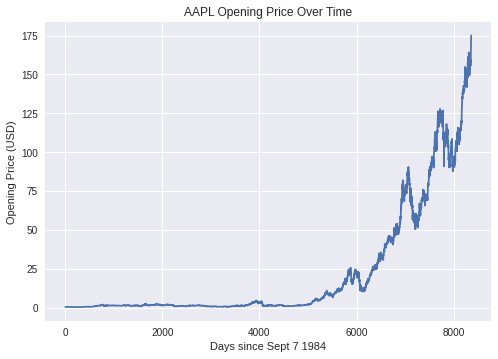

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

aapl_data = pd.read_csv("Stocks/aapl.us.txt")
print(aapl_data.head())
plt.plot(aapl_data.Open);
plt.xlabel("Days since Sept 7 1984")
plt.ylabel("Opening Price (USD)");
plt.title("AAPL Opening Price Over Time")

### **LSTM for Numerical Sequences**

### To do:


*   Plagiarize less - everything is mostly changed except: (1) get_batch to process multiple batches, (2) change LSTM() network architecture (maybe use the one from earlier homework), (3) change eval code, (4) why is test_data not scaled?
*   Validation metrics (MAE per sector)
*   Preprocess all stock data by sector/S&P
*   Implement mini-batching (looking at fixed-length sequences of various stocks)
*   Characterize base LSTM
*   Attention
*   Get S&P 500 info/sector info/stock symbols

LSTM for Numerical Sequences based on:
https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/


In [32]:
# from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [33]:
# Preprocess the data, select the appropriate stocks and convert to numpy
# Rescale training data between -1 and 1
stock = 'aapl'
stock_pd_frame = pd.read_csv("Stocks/{}.us.txt".format(stock))
stock_np = np.asarray(stock_pd_frame.Open)

train_size = 500
test_size = 12

train_data = stock_np[-train_size-test_size:-test_size]
test_data = stock_np[-test_size:]

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1, 1))

In [34]:
# helper method to get a training sequence starting at a particular point in the sequence
def get_batch(input_data, seq_len, i):
    train_seq = input_data[i:i+seq_len]
    train_label = input_data[i+seq_len:i+seq_len+1]
    return (train_seq ,train_label)

In [35]:
# LSTM class module defined
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [100]:
epochs = 150
seq_len = 12
print_and_save_interval = 1
num_batches = len(train_data_normalized) - seq_len

model = LSTM().to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


print(model)
#Training Loop

def train(model, epochs):
    #Save losses
    tr_losses = np.zeros(epochs)

    for epoch in range(epochs):
        for j in range(num_batches):
            # Fetch the batched data and push to GPU
            X, y = get_batch(train_data_normalized, seq_len, j)
            X = torch.Tensor(X).to(device)
            y = torch.Tensor(y).to(device)

            # Zero out the gradients and hidden cells
            optimizer.zero_grad()
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                            torch.zeros(1, 1, model.hidden_layer_size).to(device))

            # Compute predicted value
            y_pred = model(X)

            # Compute loss and backpropagate
            loss = criterion(y_pred, torch.flatten(y))
            loss.backward()
            optimizer.step()

            # Record average loss over each epoch
            tr_losses[epoch] += loss.item()/num_batches

        # Report loss every few epochs
        if epoch % print_and_save_interval == 0:
            print ('Epoch [{}/{}], Training Loss: {:.4f}'.format(epoch+1, epochs, tr_losses[epoch]))
    return tr_losses
tr_losses = train(model,150)
#TODO: Fix bug where first training loss is underreported...

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)
Epoch [1/10], Training Loss: 0.0939
Epoch [2/10], Training Loss: 0.1570
Epoch [3/10], Training Loss: 0.1115
Epoch [4/10], Training Loss: 0.0941
Epoch [5/10], Training Loss: 0.0833
Epoch [6/10], Training Loss: 0.0752
Epoch [7/10], Training Loss: 0.0716
Epoch [8/10], Training Loss: 0.0681
Epoch [9/10], Training Loss: 0.0607
Epoch [10/10], Training Loss: 0.0585


Text(0, 0.5, 'Loss (L1 Distance)')

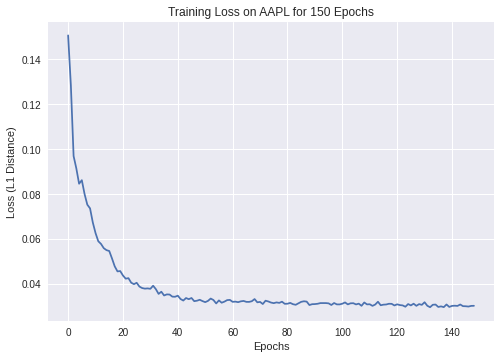

In [37]:
plt.plot(tr_losses[1:]);
plt.title('Training Loss on AAPL for 150 Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (L1 Distance)')

In [38]:
num_preds = 12

test_inputs = np.ndarray.flatten(train_data_normalized[-seq_len:]).tolist()

model.eval()

for i in range(num_preds):
    seq = torch.FloatTensor(test_inputs[-seq_len:]).to(device)
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                        torch.zeros(1, 1, model.hidden_layer_size).to(device))
        test_inputs.append(model(seq).item())

In [39]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[seq_len:] ).reshape(-1, 1))


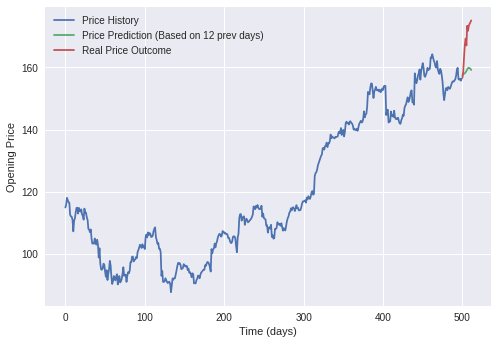

In [40]:
ts = np.arange(0,train_size + test_size,1)
plt.plot(ts[:train_size],train_data)
plt.plot(ts[-test_size:],actual_predictions)
plt.plot(ts[-test_size:],stock_np[-test_size:])
plt.xlabel('Time (days)')
plt.ylabel('Opening Price')
plt.legend(['Price History', 'Price Prediction (Based on 12 prev days)','Real Price Outcome'])

### Genetic Algorithm Approach
Referenced: [Paras Chopra - Towards Data Science](https://towardsdatascience.com/reinforcement-learning-without-gradients-evolving-agents-using-genetic-algorithms-8685817d84f)



In [59]:
import time
import math
import copy
import torch.nn.functional as F

In [57]:
for param in model.parameters():
  try:
    print(param.bias)
  except:
    pass

In [104]:
def random_models(num_models):
    models = []
    for i in range(num_models):
        model = LSTM().to(device)

        #Not using GD for Genetic Algo, turn off grads
        for param in model.parameters():
            model.requites_grad = False
        
        models.append(model)
    
    return models    

In [178]:
def eval_model(model):

    epochs = 1 #Epochs without gradients don't really make sense.
    tr_losses = np.zeros(epochs)

    for epoch in range(epochs):
        num_batches_eval = num_batches
        for j in range(num_batches_eval): #was num_batches
            # Fetch the batched data and push to GPU
            X, y = get_batch(train_data_normalized, seq_len, j)
            X = torch.Tensor(X).to(device)
            y = torch.Tensor(y).to(device)

            with torch.no_grad():
                #zero out the hidden state
                model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                            torch.zeros(1, 1, model.hidden_layer_size).to(device))

                # Compute predicted value
                y_pred = model(X)

                # Compute loss
                loss = criterion(y_pred, torch.flatten(y))

            # Record average loss over each epoch
            tr_losses[epoch] += loss.item()/num_batches_eval
    return tr_losses

def fitness_test(models):
    # Score a bunch of models (golf rules)
    scores = np.zeros(len(models))
    for i,model in enumerate(models):
        scores[i] = eval_model(model).mean()
    return scores

def mutate(model):
    # Modify weights with Gaussian noise - tunable std dev
    child_model = copy.deepcopy(model)

    mutation_power = 0.1 #tune this

    for param in child_model.parameters():
        param.data += torch.empty(param.shape).normal_(mean=0,std=mutation_power).to(device)

    return child_model.to(device)

def make_babies(models, sorted_inds):
    # sorted_inds will be the top group of parents that performed the best
    # !make sure sorted is going the correct direction
    N = len(sorted_inds)

    babies = []
    keep = 1 
    # Make equal amount of new babies which are mutations of the top parents
    for i in range(len(models)-keep):
        mutate_ind = np.random.choice(sorted_inds)
        babies.append(mutate(models[mutate_ind]))
    #Keep the best parent # TODO: implement keep top k
    babies.append(models[sorted_inds[0]])
    best_baby_ind = len(babies)-1 #last bab is superb

    return babies, best_baby_ind



In [ ]:
generations = 1000

num_models = 50
num_children = 10

tst_models = random_models(num_models)

min_scores = []
for gen in range(generations):
    scores = fitness_test(tst_models)
    print('Gen {}, Mean score: {:.6f}, Best score: {:.6f}'.format(gen, scores.mean(), scores.min()))
    min_scores.append(scores.min())
    sorted_inds = np.argsort(scores)
    tst_models, best_ind = make_babies(tst_models, sorted_inds)

Gen 0, Mean score: 0.577737, Best score: 0.540112
Gen 0, Mean score: 0.577737, Best score: 0.540112
Gen 1, Mean score: 0.583006, Best score: 0.462819
Gen 1, Mean score: 0.583006, Best score: 0.462819
Gen 2, Mean score: 0.581847, Best score: 0.412628
Gen 2, Mean score: 0.581847, Best score: 0.412628
Gen 3, Mean score: 0.599492, Best score: 0.250499
Gen 3, Mean score: 0.599492, Best score: 0.250499
Gen 4, Mean score: 0.598310, Best score: 0.228157
Gen 4, Mean score: 0.598310, Best score: 0.228157
Gen 5, Mean score: 0.641038, Best score: 0.157767
Gen 5, Mean score: 0.641038, Best score: 0.157767
Gen 6, Mean score: 0.691905, Best score: 0.157767
Gen 6, Mean score: 0.691905, Best score: 0.157767
Gen 7, Mean score: 0.735250, Best score: 0.157767
Gen 7, Mean score: 0.735250, Best score: 0.157767
Gen 8, Mean score: 0.800477, Best score: 0.157767
Gen 8, Mean score: 0.800477, Best score: 0.157767
Gen 9, Mean score: 0.941436, Best score: 0.157767
Gen 9, Mean score: 0.941436, Best score: 0.157767


### Loss vs Generation for  GA

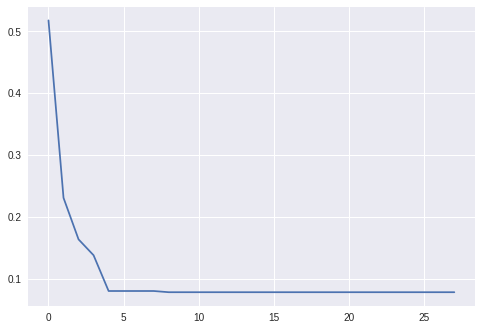

In [175]:
plt.plot(min_scores)

To do: 